Future fee income
Important Assumptions for Future Fee Projection
1. This projection assumes no prepayments or defaults on loans. In reality, loans may be paid off early or default, reducing actual future fee income.
2. It assumes the servicing fee rates remain constant as per the FY2025 rates applied.
3. It assumes loans continue to amortize according to their original terms without any modifications.
4. The `TermInMonths` is strictly adhered to; fees cease once the loan's original term expires.
6. Months elapsed and projection calculations start from `FirstDisbursementDate`.

In [47]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

# --- Configuration for Projection ---
PROJECTION_MONTHS = 24 

df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv',
                 parse_dates=['ApprovalDate', 'AsOfDate', 'FirstDisbursementDate'], low_memory=False)

# --- Step 1: Filter only current loans ---
df['LoanStatus'] = df['LoanStatus'].astype(str).str.strip().str.upper()
df = df[df['LoanStatus'] == 'EXEMPT'].copy()
total_loans = len(df)

# --- Step 2: Identify rows with missing values in required columns ---
required_cols = ['GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate', 'AsOfDate', 'TermInMonths', 'InitialInterestRate', 'FirstDisbursementDate']
missing_counts = df[required_cols].isna().sum()
num_missing_loans = df[required_cols].isnull().any(axis=1).sum()

# --- Step 2.5: Fill missing InitialInterestRate with FY average, fallback to overall average ---
def get_fiscal_year(date):
    return date.year + 1 if date.month >= 10 else date.year

df['FiscalYear'] = df['ApprovalDate'].apply(get_fiscal_year)

# Count missing before filling to track effectiveness
initial_missing_rate_count = df['InitialInterestRate'].isna().sum()

# Compute fiscal year averages and overall average for fallback
fy_avg_interest = df.groupby('FiscalYear')['InitialInterestRate'].mean()
overall_avg_rate = df['InitialInterestRate'].mean()

# Track how many values are filled by each method
fy_fill_count = 0
fallback_fill_count = 0

# Custom fill function that tracks the type of fill
def fill_missing_rate(row):
    global fy_fill_count, fallback_fill_count 
    if pd.isnull(row['InitialInterestRate']):
        fy_avg = fy_avg_interest.get(row['FiscalYear'], np.nan)
        if not pd.isnull(fy_avg):
            fy_fill_count += 1
            return fy_avg
        else:
            fallback_fill_count += 1
            return overall_avg_rate
    return row['InitialInterestRate']

# Apply the custom fill function row-wise
df['InitialInterestRate'] = df.apply(fill_missing_rate, axis=1)

# Count after filling to see how many were successfully filled
final_missing_rate_count = df['InitialInterestRate'].isna().sum()
filled_total = initial_missing_rate_count - final_missing_rate_count

# --- Step 3: Drop rows with missing critical fields ---
df = df.dropna(subset=required_cols).copy()
cleaned_loans = len(df)

# --- Step 4: Calculate months elapsed using relativedelta ---
def calculate_months_elapsed(row):
    if pd.isnull(row['AsOfDate']) or pd.isnull(row['FirstDisbursementDate']):
        return np.nan 
    delta = relativedelta(row['AsOfDate'], row['FirstDisbursementDate'])
    return delta.years * 12 + delta.months

df['MonthsElapsed'] = df.apply(calculate_months_elapsed, axis=1)
df['MonthsElapsed'] = df['MonthsElapsed'].clip(lower=0)

# --- Step 5: Calculate monthly interest rate ---
df['MonthlyRate'] = df['InitialInterestRate'] / 12 / 100

# --- Step 6: Amortization functions ---
def compute_monthly_payment(P, r, n):
    if r == 0: # If interest rate is zero, payment is simply Principal / Term
        return P / n if n > 0 else 0
    if n == 0: # If term is zero, no payment
        return 0
    # Standard formula for fixed monthly payment
    return P * r * (1 + r)**n / ((1 + r)**n - 1)

# Function to calculate the remaining loan balance after 't' payments
def remaining_balance(P, r, n, t):

    if t >= n: # If payments made are greater than or equal to total term, loan is paid off
        return 0.0
    if n == 0: # If term is zero, no balance (or no loan)
        return 0.0
    if r == 0: # Simple linear amortization if interest rate is zero
        return max(P * (1 - t / n), 0.0) # Ensure non-negative balance
    try:
        # Standard amortization formula for remaining balance
        return P * ((1 + r)**n - (1 + r)**t) / ((1 + r)**n - 1)
    except ZeroDivisionError:
        return 0.0

# --- Step 7: Apply payment and balance calculations (for current state, not directly for future projection) ---
df['MonthlyPayment'] = df.apply(lambda row: compute_monthly_payment(
    row['GrossApproval'], row['MonthlyRate'], row['TermInMonths']
), axis=1)

df['RemainingBalance'] = df.apply(lambda row: remaining_balance(
    row['GrossApproval'], row['MonthlyRate'], row['TermInMonths'], row['MonthsElapsed']
), axis=1)

# --- Step 8: Guaranteed portion of the remaining balance (for current state) ---
df['RemainingGuaranteedBalance'] = df['SBAGuaranteedApproval'] * (df['RemainingBalance'] / df['GrossApproval'])
df.loc[df['GrossApproval'] == 0, 'RemainingGuaranteedBalance'] = 0

# --- Step 9: Apply FY2025 servicing fee rates ---
def servicing_fee_rate(gross):
    if gross <= 500_000:
        return 0.00 # 0% for loans up to $500k
    elif gross <= 1_000_000:
        return 0.0017 # 0.17% for loans between $500k and $1M
    else:
        return 0.0055 # 0.55% for loans over $1M

df['ServicingFeeRate'] = df['GrossApproval'].apply(servicing_fee_rate)
df['AnnualFeeIncome'] = df['RemainingGuaranteedBalance'] * df['ServicingFeeRate']

# --- Step 10: Final total and export (for current annual fee income) ---
total_fee_income_current_annual = df['AnnualFeeIncome'].sum()

# --- Step 11: Print summary for current annual fee income ---
print("\n--- SBA 7(a) FY2025 Servicing Fee Projection (Current Annual Snapshot) ---")
print("-----------------------------------------------------------------------")
print(f"Total loans before cleaning:     {total_loans:,}")
print(f"Loans excluded (missing values): {num_missing_loans:,}")
print(f"Remaining loans used:            {cleaned_loans:,}")
print("\nMissing value counts by column (before final drop):")
print(missing_counts)
print(f"\nTotal FY2025 Projected Servicing Fee Income (Annual Snapshot): ${total_fee_income_current_annual:,.2f}")

# --- Step 12: Interest Rate Fill Summary ---
print(f"\n--- Missing Interest Rate Handling Summary ---")
print("----------------------------------------------")
print(f"Initially missing:         {initial_missing_rate_count:,}")
print(f"Filled using FY average:   {fy_fill_count:,}")
print(f"Filled using fallback avg: {fallback_fill_count:,}")
print(f"Still missing after fill:  {final_missing_rate_count:,}")


# --- Future Fee Income Projection ---
print("\n\n--- Beginning Future Servicing Fee Income Projection ---")
print("------------------------------------------------------")
print(f"Projecting for the next {PROJECTION_MONTHS} months ({PROJECTION_MONTHS / 12:.1f} years).")

def project_loan_fees_over_horizon(row, projection_horizon_months):
    """
    Projects the monthly servicing fee income for a single loan over a specified future horizon.

    Args:
        row (pd.Series): A row from the DataFrame containing loan details.
        projection_horizon_months (int): The total number of months into the future to project.

    Returns:
        list: A list of monthly projected fee incomes for each month in the projection horizon.
              Each element corresponds to a future month's projected fee.
    """
    gross_approval = row['GrossApproval']
    sba_guaranteed_approval = row['SBAGuaranteedApproval']
    term_in_months = row['TermInMonths']
    monthly_rate = row['MonthlyRate']
    months_elapsed_as_of_date = row['MonthsElapsed']
    servicing_fee_rate_annual = row['ServicingFeeRate']

    projected_monthly_fees = []

    for month_offset_from_asofdate in range(1, projection_horizon_months + 1):
        current_loan_month_in_lifecycle = months_elapsed_as_of_date + month_offset_from_asofdate

        # If the loan term has ended (or will end in this month), no more fees
        if current_loan_month_in_lifecycle > term_in_months:
            projected_monthly_fees.append(0.0)
            continue # Move to the next projection month

        # Calculate remaining balance at this future month
        rb = remaining_balance(gross_approval, monthly_rate, term_in_months, current_loan_month_in_lifecycle)

        # Calculate guaranteed portion of the remaining balance for this future month
        # Handle division by zero if GrossApproval is 0
        if gross_approval > 0:
            remaining_guaranteed_balance_future = sba_guaranteed_approval * (rb / gross_approval)
        else:
            remaining_guaranteed_balance_future = 0.0

        # Calculate monthly fee income for this future month
        # Annual fee rate is divided by 12 to get monthly rate
        monthly_fee_income_future = remaining_guaranteed_balance_future * (servicing_fee_rate_annual / 12)
        projected_monthly_fees.append(monthly_fee_income_future)

    return projected_monthly_fees

# Prepare a list to store all projected data in a long format
all_projected_data_rows = []

# Iterate through each loan in the cleaned DataFrame
for row_tuple in df.itertuples(index=True): # index=True keeps the original DataFrame index
    # Convert tuple to a Series-like object for easy access (or access by index if preferred)
    row = pd.Series(row_tuple._asdict())

    # Get the original index as a unique identifier for the loan
    loan_id = row.Index # Accessing the original DataFrame index

    # Project fees for the current loan
    projected_fees_for_loan = project_loan_fees_over_horizon(row, PROJECTION_MONTHS)

    # Append each projected monthly fee as a separate row
    for month_offset, fee in enumerate(projected_fees_for_loan):
        all_projected_data_rows.append({
            'LoanID': loan_id, # Unique identifier for the loan
            'ProjectionMonthOffset': month_offset + 1, # 1-indexed month (e.g., Month 1, Month 2, etc. from AsOfDate)
            'ProjectedMonthlyFee': fee
        })

# Create a new DataFrame from the collected projected data
projected_df = pd.DataFrame(all_projected_data_rows)

# Aggregate projected fees by month offset to get total monthly projections
monthly_total_projected_fees = projected_df.groupby('ProjectionMonthOffset')['ProjectedMonthlyFee'].sum()

# Calculate total projected fee income over the entire defined horizon
total_projected_fee_income_over_horizon = monthly_total_projected_fees.sum()

# --- Output the Future Projection Results ---
print("\n--- Projected Monthly Servicing Fee Income ---")
print("--------------------------------------------")
# FIX: Iterate through items to correctly access month number and fee amount
for month_num, fee_amount in monthly_total_projected_fees.items():
    print(f"Month {month_num:<3}: ${fee_amount:,.2f}")

print(f"\nTotal Projected Servicing Fee Income over {PROJECTION_MONTHS} months: ${total_projected_fee_income_over_horizon:,.2f}")



--- SBA 7(a) FY2025 Servicing Fee Projection (Current Annual Snapshot) ---
-----------------------------------------------------------------------
Total loans before cleaning:     280,629
Loans excluded (missing values): 4,156
Remaining loans used:            280,628

Missing value counts by column (before final drop):
GrossApproval               0
SBAGuaranteedApproval       0
ApprovalDate                0
AsOfDate                    0
TermInMonths                0
InitialInterestRate      4155
FirstDisbursementDate       1
dtype: int64

Total FY2025 Projected Servicing Fee Income (Annual Snapshot): $356,993,326.63

--- Missing Interest Rate Handling Summary ---
----------------------------------------------
Initially missing:         4,155
Filled using FY average:   87
Filled using fallback avg: 4,068
Still missing after fill:  0


--- Beginning Future Servicing Fee Income Projection ---
------------------------------------------------------
Projecting for the next 24 months (2.0 ye



--- Visualizing Projected Servicing Fee Income ---
--------------------------------------------------


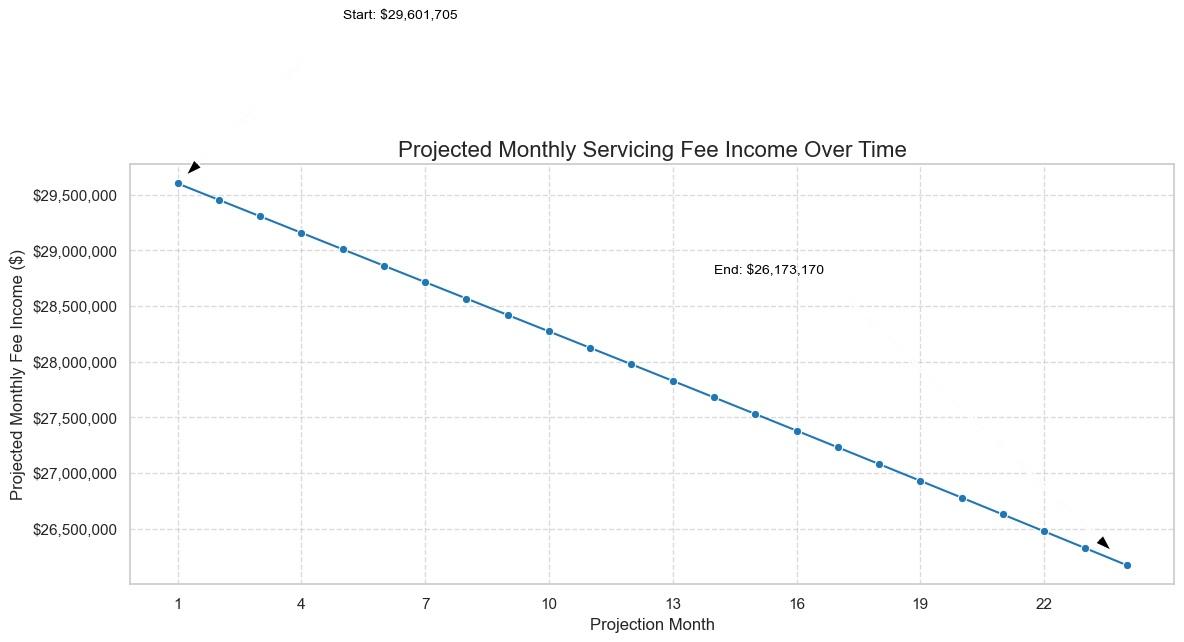

In [48]:
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns

# --- NEW VISUALIZATION SECTION ---
print("\n\n--- Visualizing Projected Servicing Fee Income ---")
print("--------------------------------------------------")

# Set a style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7)) # Adjust figure size for better readability

# Create a line plot using Seaborn
# Convert the Series to a DataFrame for easier plotting with Seaborn if needed,
# but a Series works directly with plt.plot as well.
# For Seaborn, it's often cleaner to reset the index to have 'ProjectionMonthOffset' as a column
plot_data = monthly_total_projected_fees.reset_index()
plot_data.columns = ['ProjectionMonth', 'ProjectedMonthlyFee'] # Rename columns for clarity

sns.lineplot(x='ProjectionMonth', y='ProjectedMonthlyFee', data=plot_data, marker='o', color='#1f77b4') # A nice blue color

# Add titles and labels
plt.title('Projected Monthly Servicing Fee Income Over Time', fontsize=16)
plt.xlabel('Projection Month', fontsize=12)
plt.ylabel('Projected Monthly Fee Income ($)', fontsize=12)

# Format y-axis as currency
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, p: f'${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Set x-axis ticks to show every 3 months for better readability
plt.xticks(range(1, PROJECTION_MONTHS + 1, 3))

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations for key points (e.g., start and end of projection)
plt.annotate(f'Start: ${monthly_total_projected_fees.iloc[0]:,.0f}',
             xy=(1, monthly_total_projected_fees.iloc[0]),
             xytext=(5, monthly_total_projected_fees.iloc[0] * 1.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='black')

plt.annotate(f'End: ${monthly_total_projected_fees.iloc[-1]:,.0f}',
             xy=(PROJECTION_MONTHS, monthly_total_projected_fees.iloc[-1]),
             xytext=(PROJECTION_MONTHS - 10, monthly_total_projected_fees.iloc[-1] * 1.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='black')


# Display the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # This command displays the plot in a notebook environment
